Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null
!ls

 gdrive       'Skin cancer ISIC The International Skin Imaging Collaboration'
 sample_data


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
# Count the total number of images in the dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### create a code to visualize one instance of all the nine classes present in the dataset

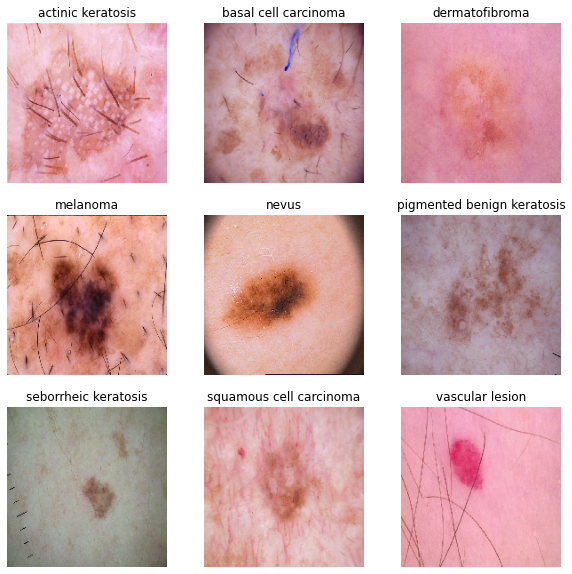

In [10]:
# Below code reads one image randomly from each class and displays for visual analysis
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img
path_dict = {}

for cname in class_names:
    path_dict[cname] = list(map(lambda x:str(data_dir_train) +'/' + cname + '/' + x, os.listdir(str(data_dir_train) + '/' + cname)))

#Visualize image 
plt.figure(figsize=(10,10))
index = 0
for cname in class_names:
    path_list = path_dict[cname][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(cname)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
# model
model = Sequential()

#Rescaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

#First Convolution layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convolution Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convolution Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
##Flatten the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 17s 87ms/step - loss: 2.0403 - accuracy: 0.2556 - val_loss: 1.8719 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 2s 38ms/step - loss: 1.7535 - accuracy: 0.3895 - val_loss: 1.5836 - val_accuracy: 0.4676
Epoch 3/20
56/56 [==============================] - 2s 38ms/step - loss: 1.5615 - accuracy: 0.4632 - val_loss: 1.4607 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 2s 38ms/step - loss: 1.4604 - accuracy: 0.4944 - val_loss: 1.6389 - val_accuracy: 0.3937
Epoch 5/20
56/56 [==============================] - 2s 38ms/step - loss: 1.4542 - accuracy: 0.4905 - val_loss: 1.3945 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 2s 38ms/step - loss: 1.3242 - accuracy: 0.5352 - val_loss: 1.4085 - val_accuracy: 0.5459
Epoch 7/20
56/56 [==============================] - 2s 38ms/step - loss: 1.2892 - accuracy: 0.5485 - val_loss: 1.3790 - val_accuracy: 0.5414
Epoch 8/20
56/56 [=====

### Visualizing training results

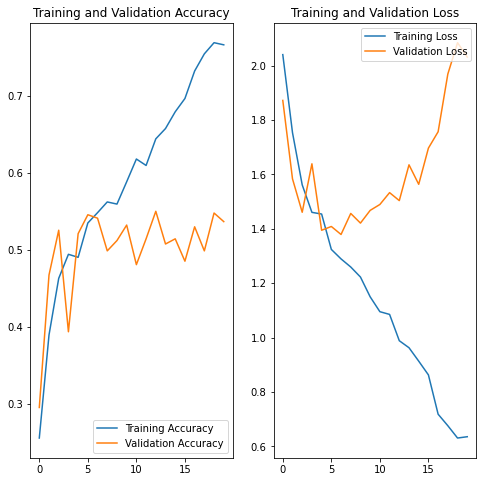

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here
#### Findings of the base model:
- The model is overfitting because:
  - There is a huge difference between the training & validation accuracy. This gap increases as the training proceeds towards the 20th epoch.
  - The validation loss is also quite high as compared to the training loss
- So it appears that the model has memorized the features of the dataset and behaves badly on the validation set.

In [17]:
# Choose an appropriate data augumentation strategy. 
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

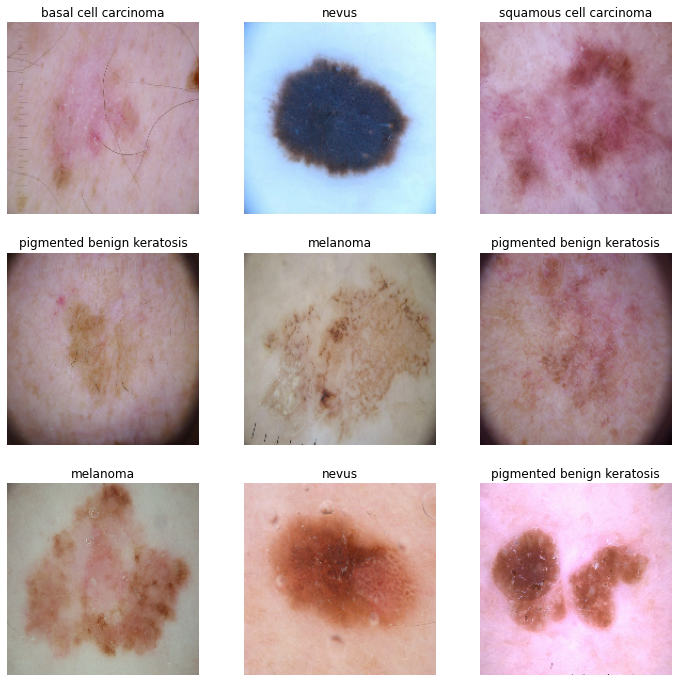

In [18]:
# visualize how the augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model, compile and train the model

In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

# model
model = Sequential()

model.add(data_augmentation)

#Rescaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

#First Convolution layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convolution Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% input units to drop.
model.add(layers.Dropout(0.5))

#Third Convolution Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Flatten the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

### Compiling the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 45ms/step - loss: 2.1601 - accuracy: 0.2277 - val_loss: 1.9575 - val_accuracy: 0.2796
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 1.7669 - accuracy: 0.3683 - val_loss: 1.6907 - val_accuracy: 0.4094
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.6524 - accuracy: 0.4118 - val_loss: 1.5875 - val_accuracy: 0.4653
Epoch 4/20
56/56 [==============================] - 2s 42ms/step - loss: 1.6264 - accuracy: 0.4079 - val_loss: 1.5567 - val_accuracy: 0.4474
Epoch 5/20
56/56 [==============================] - 2s 42ms/step - loss: 1.5276 - accuracy: 0.4570 - val_loss: 1.4870 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 2s 42ms/step - loss: 1.5732 - accuracy: 0.4336 - val_loss: 1.5089 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 2s 44ms/step - loss: 1.4646 - accuracy: 0.4894 - val_loss: 1.4360 - val_accuracy: 0.5034
Epoch 8/20
56

### Visualizing the results

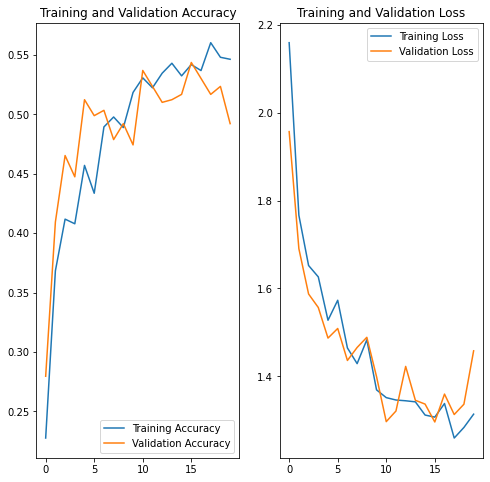

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings for the model after data augmentation
- The overfitting issue with the model is removed and both the train and validation accuracy are having consistent value (around 50%). Also the loss values are aligned as well.
- But there is no improvement in the overall train and validation accuracy numbers. They are still quite low.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
# Class distribution visualization will be performed in two steps:
# 1. Print the number of images in each class
# 2. Plot a graph of the data for better visualization 
def class_distribution(directory):
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #get the class name
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and correspondig class name.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'Num_Images'])

dataset_df = class_distribution(data_dir_train)
print(dataset_df)

                   Class_Name  Num_Images
0                    melanoma         438
1        seborrheic keratosis          77
2              dermatofibroma          95
3     squamous cell carcinoma         181
4             vascular lesion         139
5           actinic keratosis         114
6                       nevus         357
7        basal cell carcinoma         376
8  pigmented benign keratosis         462


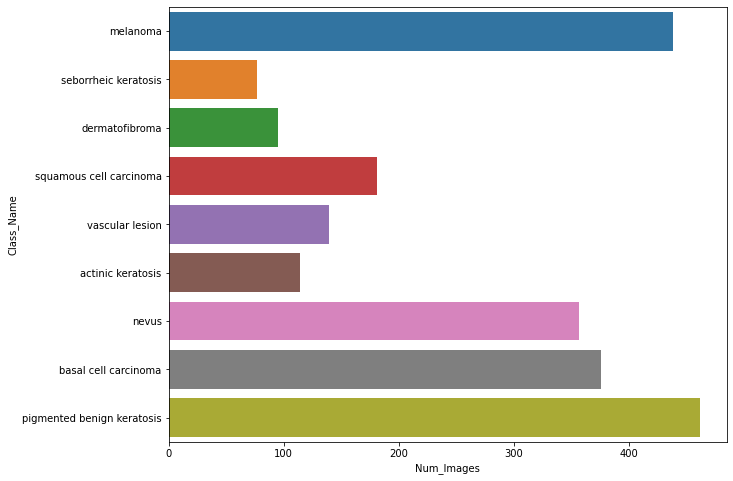

In [24]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="Num_Images", y="Class_Name", data=dataset_df, label="Name of Class")

#### **Findings after getting Class Distribution**
#### - Which class has the least number of samples?
     - "seborrheic keratosis"	has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
     - "pigmented benign keratosis" has the highest number of samples.
     -  But the classes that dominate the entire dataset in terms of proportionate number of samples are:
        - pigmented benign keratosis	
        - melanoma	
        - basal cell carcinoma	
        - nevus


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for i in class_names:
    #p = Augmentor.Pipeline(path_to_training_dataset + i)
    # The above line has been re-written as below to overcome a potential runtime error 
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F09DDDC7ED0>: 100%|██████████| 500/500 [00:19<00:00, 25.60 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F09DDE00FD0>: 100%|██████████| 500/500 [00:19<00:00, 25.29 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F09DDAA8050>: 100%|██████████| 500/500 [00:20<00:00, 24.62 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F09DDA3E090>: 100%|██████████| 500/500 [01:40<00:00,  4.95 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F09DDB45890>: 100%|██████████| 500/500 [01:21<00:00,  6.11 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0A6EEB0910>: 100%|██████████| 500/500 [00:16<00:00, 29.82 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F09DDA80B10>: 100%|██████████| 500/500 [00:41<00:00, 11.91 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F09DDAC0210>: 100%|██████████| 500/500 [00:16<00:00, 29.78 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F09DDDC7D90>: 100%|██████████| 500/500 [00:16<00:00, 30.67 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
# Import the module
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000148.jpg_e4411045-446e-49b9-803b-9d085807fa7a.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010039.jpg_7d04f509-8cc9-47d1-8acd-7ed7e23fde8e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000401.jpg_a44928bc-4b68-45f0-ba74-ed9bc1cbf25a.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000413.jpg_c0a9bca6-6fc4-4c84-be12-5ae87d1c8773.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010707.jpg_24e0f597-bef6-4403-9a74-cd25c4f1774b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010396.jpg_279e04ed-20be-4ac8-b624-70c80d6a340e.jpg',
 'Skin cancer IS

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [30]:
# variable name corrected to "path_list" from "path_list_new" which is not defined
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [32]:
new_df['Label'].value_counts()

melanoma                      500
seborrheic keratosis          500
dermatofibroma                500
squamous cell carcinoma       500
vascular lesion               500
actinic keratosis             500
nevus                         500
basal cell carcinoma          500
pigmented benign keratosis    500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [34]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [36]:
# model
model = Sequential()

#Rescaling/normalization Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

#First Convolution layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

#Second Convolution Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% input units to drop.
model.add(layers.Dropout(0.5))

#Third Convolution Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

#### Compile your model (Choose optimizer and loss function appropriately)

In [37]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [38]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 37s 210ms/step - loss: 2.3219 - accuracy: 0.1437 - val_loss: 2.1472 - val_accuracy: 0.1759
Epoch 2/30
169/169 [==============================] - 25s 142ms/step - loss: 1.8935 - accuracy: 0.2782 - val_loss: 1.6501 - val_accuracy: 0.4016
Epoch 3/30
169/169 [==============================] - 25s 141ms/step - loss: 1.5648 - accuracy: 0.3993 - val_loss: 1.4835 - val_accuracy: 0.4336
Epoch 4/30
169/169 [==============================] - 26s 151ms/step - loss: 1.4604 - accuracy: 0.4431 - val_loss: 1.4207 - val_accuracy: 0.4543
Epoch 5/30
169/169 [==============================] - 25s 143ms/step - loss: 1.4264 - accuracy: 0.4603 - val_loss: 1.5642 - val_accuracy: 0.4001
Epoch 6/30
169/169 [==============================] - 25s 144ms/step - loss: 1.3384 - accuracy: 0.4831 - val_loss: 1.3561 - val_accuracy: 0.4774
Epoch 7/30
169/169 [==============================] - 25s 144ms/step - loss: 1.3061 - accuracy: 0.5087 - val_loss: 1.2868 - val_accuracy: 0.5

#### Visualize the model results

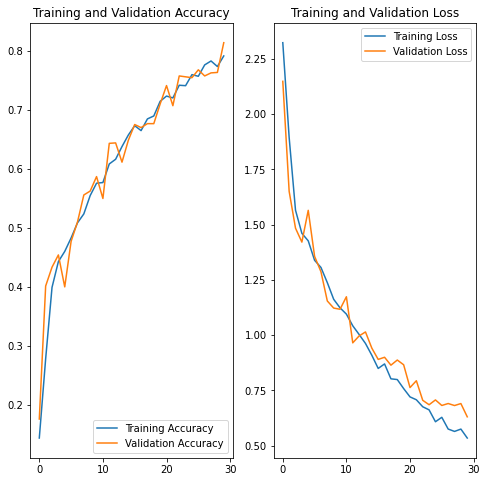

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Final result analysis 
- The graphs above show the following trends:
   1. Training and validation accuracy is aligned and there is a continuous increase in these values as the training goes ahead. 
   2. The training and validation losses also decrease as the training proceeds.
- The initial problem of overfitting has been resolved. Also both the training and validation accuracy values are quite good (more that 80%) which was lesser even after data augmentation.
- This training and validation accuracy improvement is achieved after addressing and solving the class imbalance issue in the original dataset.

